In [1]:
import os
import glob
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib

# Hyperparameter

In [2]:
# data param
day_len = 30
total_months = (2100-2015+1)*12
batch_size = 12

# model param
num_filters = 16

# Dataset

In [3]:
data_models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
dmodel = 'IPSL-CM6A-LR' # np.random.choice(np.array(data_models))  # TODO: choose a model
scenarios = ['ssp126', 'ssp370', 'ssp585']
scenario = scenarios[0]

# load historical data
dx_temp = xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(dmodel)).tas
dx_prec = xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(dmodel)).pr

# load prediction of climate until 2100 and concatanate with historical data
dx_temp_future = xr.open_mfdataset('data/near_surface_air_temperature/{}/{}/*.nc'.format(scenario, dmodel)).tas
dx_temp_future = xr.concat((dx_temp, dx_temp_future), dim='time')
dx_prec_future = xr.open_mfdataset('data/precipitation_flux/{}/{}/*.nc'.format(scenario, dmodel)).pr
dx_prec_future = xr.concat((dx_prec, dx_prec_future), dim='time')



In [4]:
# Preprocessing
train_max_index = dx_temp.shape[0] - (365*14)

min_temp = np.min(dx_temp[:train_max_index])
max_temp = np.max(dx_temp[:train_max_index])

min_prec = np.min(dx_prec[:train_max_index])
max_prec = np.max(dx_prec[:train_max_index])

min_input= -1
max_input = 1

dx_temp_future = (dx_temp_future - min_temp) * (max_input - min_input) / (max_temp - min_temp)
dx_prec_future = (dx_prec_future - min_prec) * (max_input - min_input) / (max_prec - min_prec)

### Generator
one could also use just function. Systematically sliding window to predict all future months using timestamp index

In [5]:
def gen_future_climate():
#     first_month = (2015-1850)*12 + 1  # int index of which month january 2015 is with 0 being january 1850

    counter = 0
    while counter < total_months: # predict from 2015 to 2100, excluding last month
        cyear = (counter//12) + 2015
        
        cmonth = (counter+1) % 12
        
        if cmonth == 0:
            cmonth = 12
        
        current_timestamp = pd.Timestamp(cyear, cmonth, 1)
        input_start_timestamp = current_timestamp - pd.Timedelta(day_len-1, unit='day')

        counter += 1
       
        data = np.stack((np.array(dx_temp_future.loc[input_start_timestamp:current_timestamp+pd.Timedelta(1,unit='day')]),
                         np.array(dx_prec_future.loc[input_start_timestamp:current_timestamp+pd.Timedelta(1,unit='day')])),
                         axis=-1)
        
        yield data
    

In [6]:
# data pipeline
ds_future = tf.data.Dataset.from_generator(generator=gen_future_climate, 
                                           output_types=(tf.float32)).batch(batch_size)

In [7]:
for i in ds_future.take(1):
    print(i.shape)

(12, 30, 36, 72, 2)


# Model

In [8]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvLSTM, self).__init__()
        
        do = 0.2
        self.convlstm2D_1 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                       padding="same", return_sequences=True,
                                                       activation = "tanh", dropout= do)
        self.bn_1 = tf.keras.layers.BatchNormalization()
        #self.acti_1 = tf.keras.layers.Activation(activation)
        
        self.convlstm2D_2 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                       padding="same", return_sequences=True,
                                                       activation = "tanh",dropout=do)
        self.bn_2 = tf.keras.layers.BatchNormalization()
        #self.acti_2 = tf.keras.layers.Activation(activation)


        self.convlstm2D_3 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                       padding="same", return_sequences=True,
                                                       activation = "tanh",dropout=do)
        self.bn_3 = tf.keras.layers.BatchNormalization()
        #self.acti_3 = tf.keras.layers.Activation(activation)
        
        self.convlstm2D_4 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                       padding="same", return_sequences=True,
                                                       activation = "tanh",dropout=do)
        self.bn_4 = tf.keras.layers.BatchNormalization()
        #self.acti_4 = tf.keras.layers.Activation(activation)
        
        # convolve over time, lat, lon. This means that we assume timesteps close to each other share local similarities
        self.conv3d = tf.keras.layers.Conv3D(filters = 2, kernel_size = (3,3,3), 
                                             activation= "tanh", padding="same")
        
        self.do3d = tf.keras.layers.Dropout(do)
        # computed convolved sum over all time dimension to get a single time slice
        self.bottleneck = tf.keras.layers.Conv3D(filters=1, kernel_size=1, activation="relu",strides=1)


    def call(self, x, training, input_shape):
        # (batch, time, lat, lon, channel)
        x = tf.ensure_shape(x, input_shape) 
        # (batch, time, lat, lon, channel)
        x = self.convlstm2D_1(x,training= training)
        # (batch, time, lat1, lon1, filter1)
        x = self.bn_1(x,training = training)
        
        x = self.convlstm2D_2(x,training = training)
        x = self.bn_2(x,training = training)
        
        x = self.convlstm2D_3(x,training = training)
        x = self.bn_3(x,training = training)
        
        x = self.convlstm2D_4(x,training = training)
        x = self.bn_4(x, training = training)
        # (batch, time, lat4, lon4, filter4)
        x = self.do3d(x,training= training)
        x = self.conv3d(x)
        # (batch, newtime, newlat, newlon, newfilter=2)
        
        x = tf.transpose(x, [0,4,2,3,1])
        # (batch, 2, lat, lon, time)
        x = self.bottleneck(x)
        # (batch, 2, lat, lon, 1)
        
        x = tf.transpose(x, [0,4,2,3,1])
        # (batch, 1, lat, lon, 2)
        x = tf.squeeze(x,axis=1)
        # (batch, lat, lon, 2)
        
        return x

In [9]:
model = ConvLSTM(num_filters=num_filters)
input_shape = (batch_size, day_len, 36, 72, 2)

# Deployment

In [10]:
def load_weights(model, weight_file, dataset, input_shape):
    """
    Builds the model by using the call method on input and then loads the weights.
    """
    for data in dataset.take(1):
        model(data, training=False, input_shape=input_shape)
    
    model.load_weights(weight_file)
    return None

In [11]:
load_weights(model, 'model_weights/Version_dropout_0.2both.hdf5', ds_future, input_shape)

In [13]:
for data in ds_future:
    try:
        predictions = np.concatenate((predictions, model(data, training=False, input_shape=input_shape)), axis=0)    
    except Exception as e:
        predictions = model(data, training=False, input_shape=input_shape)

    print(predictions.shape)

first
(120, 36, 72, 2)
first
(132, 36, 72, 2)
first
(144, 36, 72, 2)
first
(156, 36, 72, 2)
first
(168, 36, 72, 2)
first
(180, 36, 72, 2)
first
(192, 36, 72, 2)
first
(204, 36, 72, 2)
first
(216, 36, 72, 2)
first
(228, 36, 72, 2)
first
(240, 36, 72, 2)
first
(252, 36, 72, 2)
first
(264, 36, 72, 2)
first
(276, 36, 72, 2)
first
(288, 36, 72, 2)
first
(300, 36, 72, 2)
first
(312, 36, 72, 2)
first
(324, 36, 72, 2)
first
(336, 36, 72, 2)
first
(348, 36, 72, 2)
first
(360, 36, 72, 2)
first
(372, 36, 72, 2)
first
(384, 36, 72, 2)
first
(396, 36, 72, 2)
first
(408, 36, 72, 2)
first
(420, 36, 72, 2)
first
(432, 36, 72, 2)
first
(444, 36, 72, 2)
first
(456, 36, 72, 2)
first
(468, 36, 72, 2)
first
(480, 36, 72, 2)
first
(492, 36, 72, 2)
first
(504, 36, 72, 2)
first
(516, 36, 72, 2)
first
(528, 36, 72, 2)
first
(540, 36, 72, 2)
first
(552, 36, 72, 2)
first
(564, 36, 72, 2)
first
(576, 36, 72, 2)
first
(588, 36, 72, 2)
first
(600, 36, 72, 2)
first
(612, 36, 72, 2)
first
(624, 36, 72, 2)
first
(636,

In [14]:
np.save('results/pred_version1_{}'.format(scenario), predictions)

# Plot

In [15]:
plt.rcParams["animation.html"] = "jshtml"  # allow animation for jupyter
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.labelleft'] = False

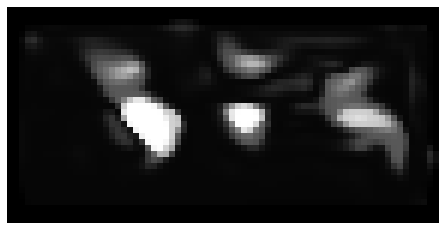

In [16]:
frames = []  # append each image
fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

for timeindex in range(total_months):  # animate for 1 yr

    frames.append([plt.imshow(predictions[timeindex,:,:,0], # TODO: change to 1 to save NPP
                              cmap='gray', origin='lower', animated=True)])

ani = matplotlib.animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat=True)
# ani.save('figs/pred_v1_{}_LAI.gif'.format(scenario), writer='imagemagick', fps=60)
ani
